###Download and unzip the Crack Dataset consisting of total ~11,200 images, (from 12 different datasets)###

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!gdown --id 1xrOqv0-3uMHjZyEUrerOYiYXW_E8SUMP

Downloading...
From: https://drive.google.com/uc?id=1xrOqv0-3uMHjZyEUrerOYiYXW_E8SUMP
To: /content/crack_segmentation_dataset.zip
2.13GB [00:22, 93.7MB/s]


In [3]:
!unzip /content/crack_segmentation_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2817_34_1828_3755_3708.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2838_547_1340_1856_2398.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01695_806_127_1820_1549.jpg  
  inflating: crack_segmentation_dataset/train/masks/noncrack_noncrack_concrete_wall_12_7.jpg.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171456_1281_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Volker_DSC01706_240_1123_1495_1323.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2865_413_845_3382_2544.jpg  
  inflating: crack_segmentation_dataset/train/masks/CRACK500_20160405_171219_1_361.jpg  
  inflating: crack_segmentation_dataset/train/masks/Rissbilder_for_Florian_9S6A2823_571_2290_3080_2668.jpg  
  inflating: crack_segmentation_dataset/train/mask

###Clone Matterport's MASK-RCNN Implementation###

In [4]:
!git clone https://github.com/Cpruce/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 1039, done.
remote: Total 1039 (delta 0), reused 0 (delta 0), pack-reused 1039
Receiving objects: 100% (1039/1039), 112.34 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (618/618), done.


###Clone Assignment repo###

In [1]:

## Need to do from this ...
from getpass import getpass
import os
import urllib

user = getpass('Github user')
password = getpass('Github password')
os.environ['GITHUB_AUTH'] = user + ':' + urllib.parse.quote_plus(password)
#... to this, as the repository is private

!git clone  https://$GITHUB_AUTH@github.com/loong/shubham-fv-test-mask-rcnn.git

Github user··········
Github password··········
Cloning into 'shubham-fv-test-mask-rcnn'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 75 (delta 17), reused 66 (delta 9), pack-reused 0
Unpacking objects: 100% (75/75), done.


#####Switching to Tensorflow 1.x#####

In [2]:
%tensorflow_version 1.x
#!pip install q keras==2.1.5

TensorFlow 1.x selected.


In [3]:
import tensorflow
print(tensorflow.__version__)
import keras
print(keras.__version__)

1.15.2
2.3.1


Using TensorFlow backend.


In [4]:
%cd /content/Mask_RCNN

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = '/content/drive/My Drive/FireVisor/task_3/mask_with_mobilenet'

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



/content/Mask_RCNN


In [5]:
class CrackConfig(Config):

    # Give the configuration a recognizable name
    NAME = "crack"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE  = 'mobilenetv2'

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 crack (class)

   
    # Our training image size is (448, 448)
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # Train 64 top ROI's
    TRAIN_ROIS_PER_IMAGE = 64


    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300  # 300 to get frequent reading from tensorboard, after each epoch

    VALIDATION_STEPS = 50
    
config = CrackConfig()
config.display()


Configurations:
BACKBONE                       mobilenetv2
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
###Use CrackDataset_with_its_utils.py to get CracksDataset class###
%cd /content/shubham-fv-test-mask-rcnn

from CrackDataset_with_its_utils import CracksDataset

train_dir = '/content/crack_segmentation_dataset/train'
test_dir = '/content/crack_segmentation_dataset/test'

# Training dataset
dataset_train = CracksDataset(utils.Dataset)
dataset_train.load_dataset(train_dir)
dataset_train.prepare()

# Validation dataset
dataset_val = CracksDataset(utils.Dataset)
dataset_val.load_dataset(test_dir)
dataset_val.prepare()

/content/shubham-fv-test-mask-rcnn


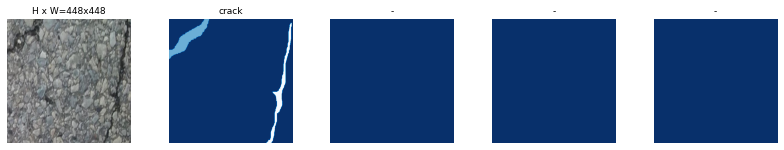

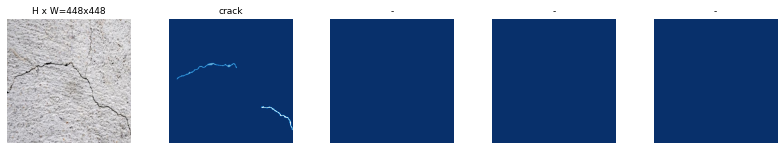

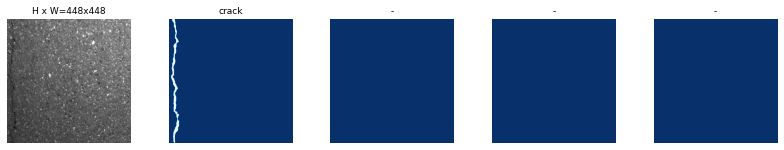

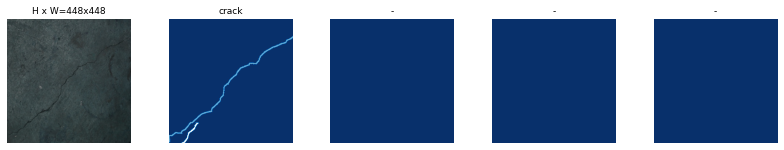

In [8]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

IMAGE_SHPE [256 256   3]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead
Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
___________

In [ ]:
## Load Imagenet weights for mobilenet

model.load_weights(model.get_imagenet_weights(), by_name=True)

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
model.keras_model.metrics_tensors = []
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(MODEL_DIR)

In [ ]:
model.train(dataset_train, dataset_val, custom_callbacks = [tensorboard_callback], learning_rate=config.LEARNING_RATE, epochs=15, layers="all")

# Model trained upto 15 epochs



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/FireVisor/task_3/mask_with_mobilenet/logs/crack20200928T1511/mask_rcnn_crack_{epoch:04d}.h5
Selecting layers to train
Conv1                  (Conv2D)
bn_Conv1               (BatchNorm)
expanded_conv_depthwise   (DepthwiseConv2D)
expanded_conv_depthwise_BN   (BatchNorm)
expanded_conv_project   (Conv2D)
expanded_conv_project_BN   (BatchNorm)
block_1_expand         (Conv2D)
block_1_               (BatchNorm)
block_1_depthwise      (DepthwiseConv2D)
block_1_depthwise_BN   (BatchNorm)
block_1_project        (Conv2D)
block_1_project_BN     (BatchNorm)
block_2_expand         (Conv2D)
block_2_               (BatchNorm)
block_2_depthwise      (DepthwiseConv2D)
block_2_depthwise_BN   (BatchNorm)
block_2_project        (Conv2D)
block_2_project_BN     (BatchNorm)
block_3_expand         (Conv2D)
block_3_               (BatchNorm)
block_3_depthwise      (DepthwiseConv2D)
block_3_depthwise_BN   (BatchNorm)
block_3_project       

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/15
300/300 [==============================] - 232s 774ms/step - loss: 3.0316 - val_loss: 2.2223

Epoch 2/15
300/300 [==============================] - 205s 685ms/step - loss: 2.6922 - val_loss: 3.2374
Epoch 3/15
300/300 [==============================] - 215s 717ms/step - loss: 2.5406 - val_loss: 2.1796
Epoch 4/15
300/300 [==============================] - 217s 722ms/step - loss: 2.5341 - val_loss: 2.5820
Epoch 5/15
300/300 [==============================] - 215s 716ms/step - loss: 2.4724 - val_loss: 2.3141
Epoch 6/15
300/300 [==============================] - 215s 715ms/step - loss: 2.4918 - val_loss: 2.6794
Epoch 7/15
300/300 [==============================] - 214s 713ms/step - loss: 2.4495 - val_loss: 1.9802
Epoch 8/15
300/300 [==============================] - 215s 715ms/step - loss: 2.4113 - val_loss: 1.9247
Epoch 9/15
300/300 [==============================] - 213s 708ms/step - loss: 2.4468 - val_loss: 2.4004
Epoch 10/15
158/300 [==============>...............] - ETA: 1:3

###Do the inference###

In [13]:
class InferenceConfig(CrackConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.8

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

IMAGE_SHPE [256 256   3]


Instructions for updating:
Use `tf.cast` instead.
Model: "mask_rcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNorm)            (None, 128, 128, 32) 128         Conv1[0][0]                      
_____________

In [24]:
image_ids = random.sample(list(dataset_val.image_ids), 5)
print(image_ids)

[403, 318, 338, 1156, 973]


original_image           shape: (256, 256, 3)         min:   29.00000  max:  136.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  448.00000  float64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 3)         min:    0.00000  max:    1.00000  uint8


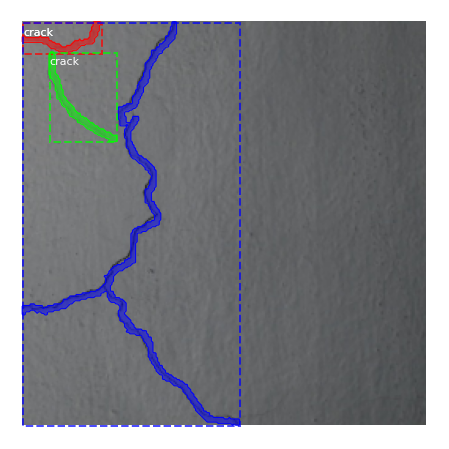

original_image           shape: (256, 256, 3)         min:    4.00000  max:  222.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  448.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  uint8


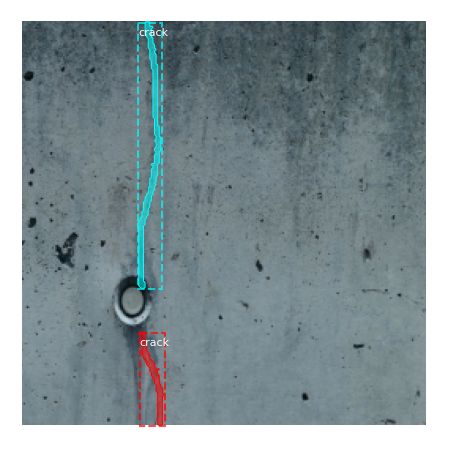

original_image           shape: (256, 256, 3)         min:    0.00000  max:  222.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  448.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  uint8


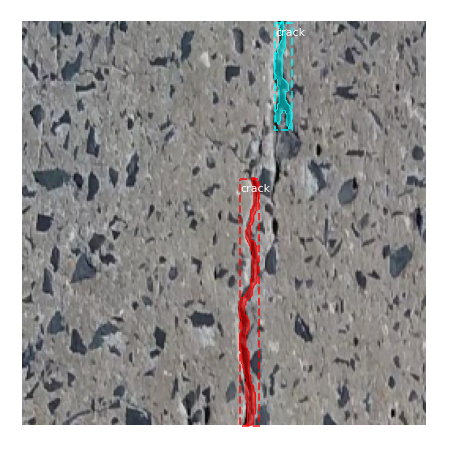

original_image           shape: (256, 256, 3)         min:   20.00000  max:   88.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1156.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8


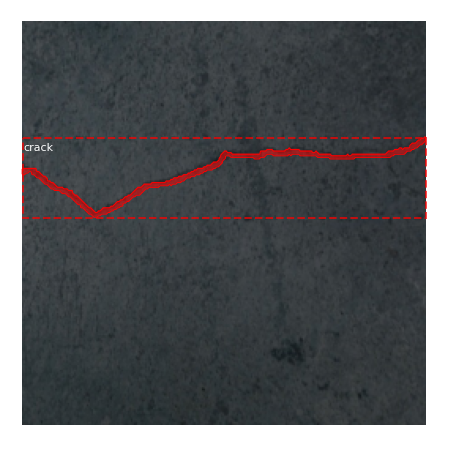

original_image           shape: (256, 256, 3)         min:   32.00000  max:  157.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  973.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:    7.00000  max:  256.00000  int32
gt_mask                  shape: (256, 256, 2)         min:    0.00000  max:    1.00000  uint8


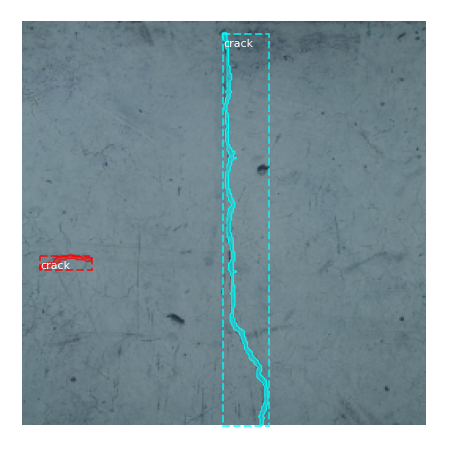

In [25]:

original_images = []
for image_id in image_ids:

  original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset_val, inference_config, 
                            image_id, use_mini_mask=False)
      
  original_images.append(original_image)

  log("original_image", original_image)
  log("image_meta", image_meta)
  log("gt_class_id", gt_class_id)
  log("gt_bbox", gt_bbox)
  log("gt_mask", gt_mask)

  visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                              dataset_train.class_names, figsize=(8, 8))

In [27]:
results = []

import time

# starting time
start = time.time()

for original_image in original_images:
  result = model.detect([original_image], verbose=1)

  results.append(result)

# end time
end = time.time()

# avg time taken per image
print(f"Runtime of the program is {(end - start)/5}")


Processing 1 images
image                    shape: (256, 256, 3)         min:   29.00000  max:  136.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -94.70000  max:   32.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    4.00000  max:  222.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -119.70000  max:  118.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  222.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  116.10000

In [28]:
####Visualize predictions####

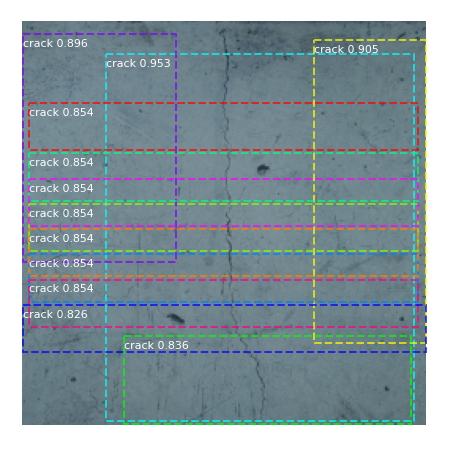

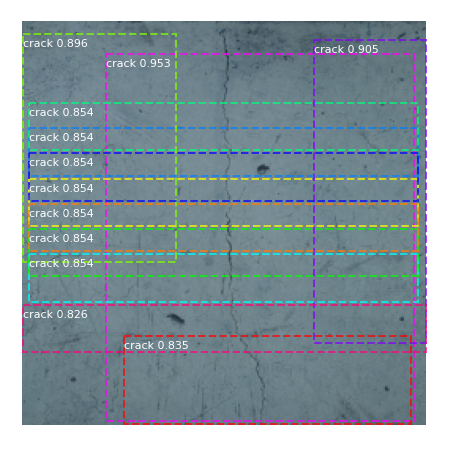

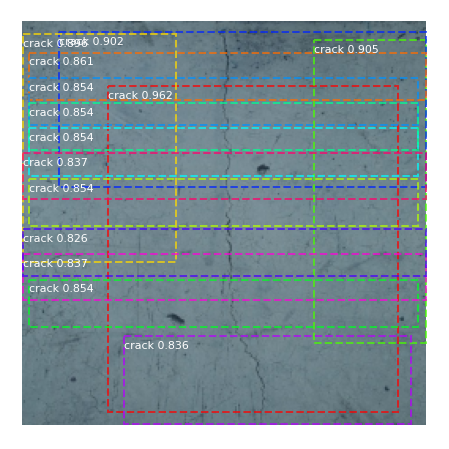

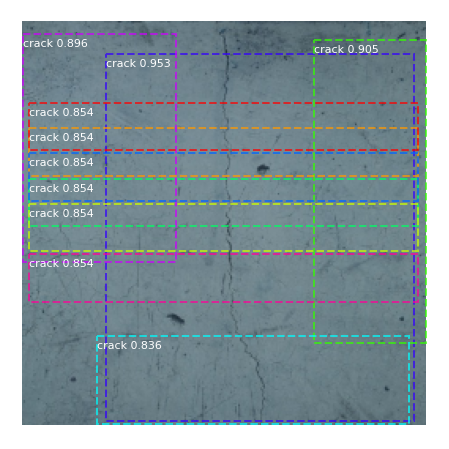

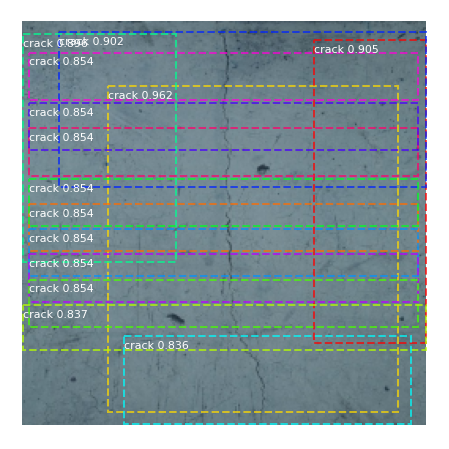

In [29]:
for result in results:

  r = result[0]
  visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())